<a href="https://colab.research.google.com/github/LanxyL/Capstone3---Recommendation-System/blob/main/Recommendation_System_on_Amazon_home_kitchen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import gzip

def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

reviews = getDF('drive/My Drive/reviews_Home_and_Kitchen.json.gz')
meta = getDF('drive/My Drive/meta_Home_and_Kitchen.json.gz')

In [3]:
reviews.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A210NOCSTBT4OD,0076144011,Sheila,"[0, 0]",Have you ever thought about how you met your b...,4.0,Lovely,1349308800,"10 4, 2012"
1,A28ILV4TOG8BH2,0130350591,ccjensen,"[0, 0]","The butter dish is serving us well, and keepin...",5.0,"Nice looking, and keeps the butter fresh",1300752000,"03 22, 2011"
2,A31B4D7URW4DNZ,0307394530,3Gigi3,"[11, 16]",I anxiously waited for the book I had pre orde...,2.0,Mother of the Bride,1214784000,"06 30, 2008"
3,A2HU0RPDRZZOP1,0307394530,Alexey Leontev,"[0, 0]","Fantastic book, a lot of good, original recipe...",5.0,amazing book,1277337600,"06 24, 2010"
4,A7J0XOW7DYBBD,0307394530,Allan Mar Cariaso,"[0, 0]",Can't wait to try all the amazing techniques. ...,5.0,Very helpful,1393113600,"02 23, 2014"


In [4]:
meta.head(5)

,asin,salesRank,imUrl,categories,title,description,related,price,brand
0,0076144011,{'Books': 6285595},http://g-ecx.images-amazon.com/images/G/01/x-s...,[[Home & Kitchen]],"Ninjas, Piranhas, and Galileo",NaN,NaN,NaN,NaN
1,0130350591,{'Kitchen & Dining': 459680},http://ecx.images-amazon.com/images/I/21zcx6RC...,"[[Home & Kitchen, Kitchen & Dining, Dining & E...",Le Creuset Kiwi (Green) Butter Dish Stoneware,Each piece of Le Creuset dinnerware is crafted...,NaN,NaN,NaN
2,0307394530,"{'Arts, Crafts & Sewing': 3597}",http://ecx.images-amazon.com/images/I/51A4FWuj...,"[[Home & Kitchen, Artwork, Posters & Prints]]",Martha Stewart's Wedding Cakes,Of all the decisions that go into planning a w...,"{'also_bought': ['144630163X', '1402717733', '...",14.99,Random House
3,0439903491,{'Software': 7065},http://ecx.images-amazon.com/images/I/61tVxcko...,"[[Home & Kitchen, Artwork, Posters & Prints]]",NaN,Shiver me timbers! Solve I SPY pirate picture ...,"{'also_viewed': ['B000YFSZU8', 'B0016KWZB0', '...",29.99,NaN
4,0578060604,NaN,http://ecx.images-amazon.com/images/I/41aCELWJ...,"[[Home & Kitchen, Furniture, Kitchen & Dining ...",Build A Maloof Inspired Low Back Dining Chair ...,The Maloofinspired Low Back Dining Chair is no...,{'also_viewed': ['B004IO6RS8']},NaN,NaN


In [5]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4253926 entries, 0 to 4253925
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   reviewerID      object 
 1   asin            object 
 2   reviewerName    object 
 3   helpful         object 
 4   reviewText      object 
 5   overall         float64
 6   summary         object 
 7   unixReviewTime  int64  
 8   reviewTime      object 
dtypes: float64(1), int64(1), object(7)
memory usage: 324.5+ MB


In [6]:
meta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 436988 entries, 0 to 436987
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   asin         436988 non-null  object 
 1   salesRank    414167 non-null  object 
 2   imUrl        436617 non-null  object 
 3   categories   436988 non-null  object 
 4   title        435249 non-null  object 
 5   description  405793 non-null  object 
 6   related      300857 non-null  object 
 7   price        285168 non-null  float64
 8   brand        152611 non-null  object 
dtypes: float64(1), object(8)
memory usage: 33.3+ MB


In [7]:
#Convert 'unixReviewTime' column to datetime object
from datetime import datetime

date_times = lambda x: datetime.fromtimestamp(x).strftime('%m-%d-%Y')
reviews.unixReviewTime = reviews.unixReviewTime.apply(date_times)
reviews.unixReviewTime.head(5)

0    10-04-2012
1    03-22-2011
2    06-30-2008
3    06-24-2010
4    02-23-2014
Name: unixReviewTime, dtype: object

In [8]:
#Drop redundant column which also represents review time
reviews.drop('reviewTime', axis=1, inplace=True)

In [9]:
#Reviewer can be identified by reviewerID, drop the reviewerName column which is redundant
reviews.drop('reviewerName', axis=1, inplace=True)

In [10]:
#Drop imURL since it will not be used for the recommendation system
meta.drop('imUrl', axis=1, inplace=True)

In [11]:
combined = pd.merge(reviews, meta,on='asin', how='left')

In [12]:
combined.head(5).T

,0,1,2,3,4
reviewerID,A210NOCSTBT4OD,A28ILV4TOG8BH2,A31B4D7URW4DNZ,A2HU0RPDRZZOP1,A7J0XOW7DYBBD
asin,0076144011,0130350591,0307394530,0307394530,0307394530
helpful,"[0, 0]","[0, 0]","[11, 16]","[0, 0]","[0, 0]"
reviewText,Have you ever thought about how you met your b...,"The butter dish is serving us well, and keepin...",I anxiously waited for the book I had pre orde...,"Fantastic book, a lot of good, original recipe...",Can't wait to try all the amazing techniques. ...
overall,4,5,2,5,5
summary,Lovely,"Nice looking, and keeps the butter fresh",Mother of the Bride,amazing book,Very helpful
unixReviewTime,10-04-2012,03-22-2011,06-30-2008,06-24-2010,02-23-2014
salesRank,{'Books': 6285595},{'Kitchen & Dining': 459680},"{'Arts, Crafts & Sewing': 3597}","{'Arts, Crafts & Sewing': 3597}","{'Arts, Crafts & Sewing': 3597}"
categories,[[Home & Kitchen]],"[[Home & Kitchen, Kitchen & Dining, Dining & E...","[[Home & Kitchen, Artwork, Posters & Prints]]","[[Home & Kitchen, Artwork, Posters & Prints]]","[[Home & Kitchen, Artwork, Posters & Prints]]"
title,"Ninjas, Piranhas, and Galileo",Le Creuset Kiwi (Green) Butter Dish Stoneware,Martha Stewart's Wedding Cakes,Martha Stewart's Wedding Cakes,Martha Stewart's Wedding Cakes


In [13]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4253926 entries, 0 to 4253925
Data columns (total 14 columns):
 #   Column          Dtype  
---  ------          -----  
 0   reviewerID      object 
 1   asin            object 
 2   helpful         object 
 3   reviewText      object 
 4   overall         float64
 5   summary         object 
 6   unixReviewTime  object 
 7   salesRank       object 
 8   categories      object 
 9   title           object 
 10  description     object 
 11  related         object 
 12  price           float64
 13  brand           object 
dtypes: float64(2), object(12)
memory usage: 486.8+ MB


## **Exploratory Data Analysis**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Amazon Review Rating')

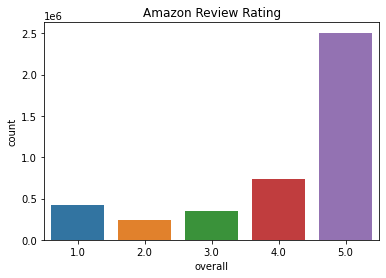

In [14]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(combined.overall)
plt.title('Amazon Review Rating')

In [15]:
combined.overall.describe()

count    4.253926e+06
mean     4.099486e+00
std      1.331712e+00
min      1.000000e+00
25%      4.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: overall, dtype: float64

In [16]:
combined.unixReviewTime = pd.to_datetime(combined.unixReviewTime)

In [17]:
combined['year'] = combined.unixReviewTime.dt.year

In [18]:
combined['month'] = combined.unixReviewTime.dt.month

Text(0.5, 1.0, 'Number of reviews over years')

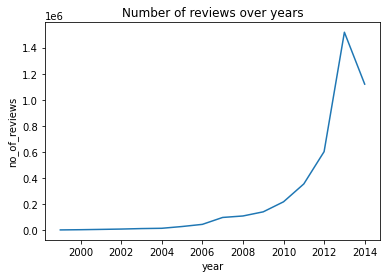

In [19]:
yearly = combined.groupby(['year'])['reviewerID'].count().reset_index()
yearly = yearly.rename(columns={'reviewerID':'no_of_reviews'})
sns.lineplot(x='year', y='no_of_reviews', data=yearly)
plt.title('Number of reviews over years')

The number of reviews increase over time. However, it went down from 2013 to 2014. The increasing trend for the reviews indicates that more and more users start using Amazon. The peak on 2013 might be raised by an promotion which boost the number of reviewer.

Text(0.5, 1.0, 'Number of reviews over month')

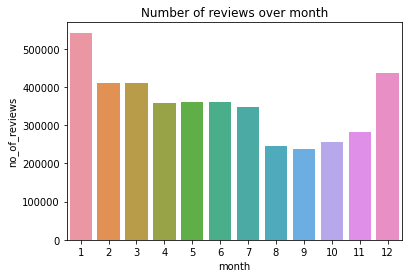

In [20]:
monthly = combined.groupby(['month'])['reviewerID'].count().reset_index()
monthly = monthly.rename(columns={'reviewerID':'no_of_reviews'})
sns.barplot(x='month', y='no_of_reviews', data=monthly)
plt.title('Number of reviews over month')

The number of reviews get highest on January and December. It might related to the holiday season. Before the holiday season, people were less interested on shopping.  

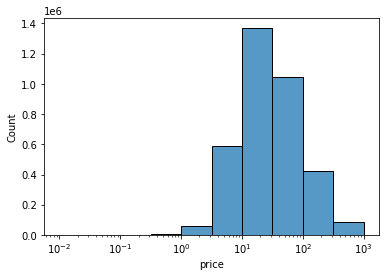

In [21]:
sns.histplot(x='price', data=combined, log_scale=True, bins=10)

In [22]:
combined.price.describe()

count    3.576482e+06
mean     5.716747e+01
std      8.738777e+01
min      1.000000e-02
25%      1.299000e+01
50%      2.620000e+01
75%      5.999000e+01
max      9.999900e+02
Name: price, dtype: float64

Most of the items are between 13 to 60 dollars. It implies that customers prefer items in this price range on Amazon. 

In [23]:
def wordlength(x):
  return len(x.split())
combined['reviewlength'] = combined.reviewText.apply(wordlength)

In [24]:
combined['reviewlength'].describe()

count    4.253926e+06
mean     7.000801e+01
std      8.227211e+01
min      0.000000e+00
25%      2.600000e+01
50%      4.400000e+01
75%      8.100000e+01
max      5.973000e+03
Name: reviewlength, dtype: float64

The average of review length is only 7 words. It is interested that the longest review has almost 6000 words. I would like to see what item it is and what does the review look like.

In [25]:
combined.iloc[combined[['reviewlength']].idxmax()].T

,3509078
reviewerID,A30UFXOF0GS9NM
asin,B007JOJ9QQ
helpful,"[4, 4]"
reviewText,I think someone left their Super Nintendo in t...
overall,4
summary,Mostly awesome except for missing edges
unixReviewTime,2013-11-04 00:00:00
salesRank,{'Home &amp; Kitchen': 3349}
categories,"[[Home & Kitchen, Vacuums & Floor Care, Vacuum..."
title,Neato XV-21 Pet &amp; Allergy Automatic Vacuum...


In [26]:
from IPython.display import display, HTML

longest_txt = combined['reviewText'].iloc[combined[['reviewlength']].idxmax()]
display(HTML(pd.DataFrame(longest_txt).to_html()))

Text(0.5, 1.0, 'Price vs. Average Rating')

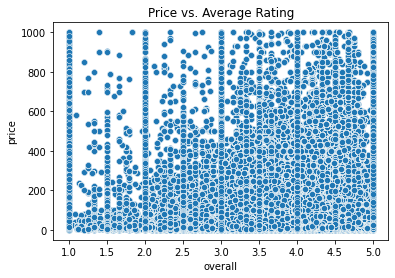

In [27]:
averageRatings = reviews.groupby('asin')['overall'].mean().reset_index()
productPrices = combined[['asin', 'price']]
price_vs_rating = pd.merge(averageRatings, productPrices, how='inner', on='asin')
sns.scatterplot(x='overall', y='price', data=price_vs_rating)
plt.title('Price vs. Average Rating')

From the scatter plot, it was not so obvious to see a relationship by looking at the exact numbers like 1, 2, 3, 4 and 5. However, if we just look at the rest of the dots, it items with lower price turn to get various rating. While high price tends to imply better quality, people who were willing to pay more gave higher rating on the products.

Text(0.5, 1.0, 'Review Length vs. Rating')

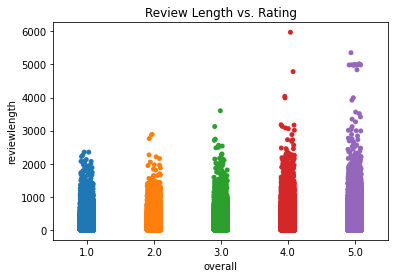

In [28]:
sns.stripplot(x='overall', y='reviewlength', data=combined, jitter=True)
plt.title('Review Length vs. Rating')

It was obvious that people who left very long review tend to rate higher on the products. Most of people review items within 1000 words.

Text(0.5, 1.0, 'Rating over Years')

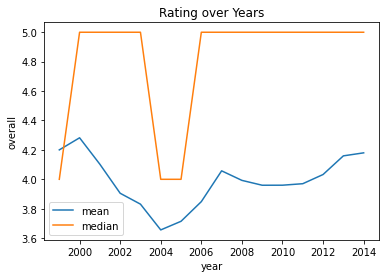

In [29]:
averageRatings_yearly = combined.groupby('year')['overall'].mean().reset_index()
medianRatings_yearly = combined.groupby('year')['overall'].median().reset_index()
sns.lineplot(x='year', y='overall', data=averageRatings_yearly, label='mean')
sns.lineplot(x='year', y='overall', data=medianRatings_yearly, label='median')
plt.title('Rating over Years')

The average rating of products is higest on 2000. It drops really fast after 2000 and reaches the low point on 2004. The median of the rating only went down to 4 on 2004 and 2005 after 2000. After 2004, the average rating climbs up but still didn't reach the high point on 2000. However, the average rating only varies between 3.6 to 4.3. The overall satisfactory is still pretty high.

In [30]:
#Make a dataframe to split product categories
productCategories = pd.DataFrame(combined.categories.values.tolist(), index = combined.asin)
productCategories.dropna(inplace=True, how='all')
productCategories = productCategories.rename(columns={0:'categories'})
productCategories = pd.DataFrame(productCategories.categories.values.tolist(), index = productCategories.categories.index)
productCategories = productCategories.rename(columns={0:'mainCategory',1:'subCategory1',2:'subCategory2',3:'subCategory3',4:'subCategory4',5:'subCategory5',6:'subCategory6#'})
productCategories.reset_index(inplace=True)
productCategories.drop_duplicates(inplace=True)

In [31]:
productCategories

,asin,mainCategory,subCategory1,subCategory2,subCategory3,subCategory4,subCategory5,subCategory6#
0,0076144011,Home & Kitchen,None,None,None,None,None,None
1,0130350591,Home & Kitchen,Kitchen & Dining,Dining & Entertaining,Serveware,Butter Dishes,None,None
2,0307394530,Home & Kitchen,Artwork,Posters & Prints,None,None,None,None
50,0439903491,Home & Kitchen,Artwork,Posters & Prints,None,None,None,None
51,0578060604,Home & Kitchen,Furniture,Kitchen & Dining Room Furniture,Chairs,None,None,None
...,...,...,...,...,...,...,...,...
4253907,B00LUVXMX0,Home & Kitchen,Bedding,Quilts,None,None,None,None
4253912,B00LVJQDBY,Home & Kitchen,Furniture,Living Room Furniture,Chairs,None,None,None
4253914,B00LXFN8MS,Home & Kitchen,Bedding,None,None,None,None,None
4253919,B00LXFP8NK,Home & Kitchen,Bedding,None,None,None,None,None


In [32]:
productCategories['subCategory1'].unique()

array([None, 'Kitchen & Dining', 'Artwork', 'Furniture', 'Bedding',
       'Storage & Organization', 'Bath', 'Heating, Cooling & Air Quality',
       'Irons & Steamers', 'Vacuums & Floor Care',
       'Accessories & Supplies', 'RV Parts & Accessories',
       "Kids' Home Store", 'Cleaning Supplies', 'Car Care',
       'Household Supplies', 'Power & Hand Tools',
       'Computers & Accessories', 'Cases', 'Bath & Body', 'Accessories'],
      dtype=object)

[Text(0, 0, 'Kitchen & Dining'),
 Text(0, 0, 'Artwork'),
 Text(0, 0, 'Furniture'),
 Text(0, 0, 'Bedding'),
 Text(0, 0, 'Storage & Organization'),
 Text(0, 0, 'Bath'),
 Text(0, 0, 'Heating, Cooling & Air Quality'),
 Text(0, 0, 'Irons & Steamers'),
 Text(0, 0, 'Vacuums & Floor Care'),
 Text(0, 0, 'Accessories & Supplies'),
 Text(0, 0, 'RV Parts & Accessories'),
 Text(0, 0, "Kids' Home Store"),
 Text(0, 0, 'Cleaning Supplies'),
 Text(0, 0, 'Car Care'),
 Text(0, 0, 'Household Supplies'),
 Text(0, 0, 'Power & Hand Tools'),
 Text(0, 0, 'Computers & Accessories'),
 Text(0, 0, 'Cases'),
 Text(0, 0, 'Bath & Body'),
 Text(0, 0, 'Accessories')]

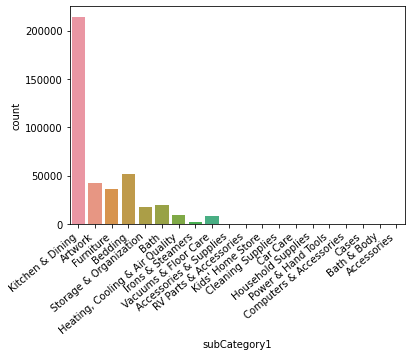

In [33]:
chart=sns.countplot(x='subCategory1', data=productCategories, )
chart.set_xticklabels(chart.get_xticklabels(), rotation=40,horizontalalignment='right')

About half of products are under Kitchen & Dining subcategory. If a smaller dataset is needed for furture modeling. We could consider extract one of the subcategory out for analysis.

In [34]:
combined=pd.merge(combined, productCategories, how='inner', on='asin')
combined.head()

,reviewerID,asin,helpful,reviewText,overall,summary,unixReviewTime,salesRank,categories,title,description,related,price,brand,year,month,reviewlength,mainCategory,subCategory1,subCategory2,subCategory3,subCategory4,subCategory5,subCategory6#
0,A210NOCSTBT4OD,0076144011,"[0, 0]",Have you ever thought about how you met your b...,4.0,Lovely,2012-10-04,{'Books': 6285595},[[Home & Kitchen]],"Ninjas, Piranhas, and Galileo",NaN,NaN,NaN,NaN,2012,10,298,Home & Kitchen,None,None,None,None,None,None
1,A28ILV4TOG8BH2,0130350591,"[0, 0]","The butter dish is serving us well, and keepin...",5.0,"Nice looking, and keeps the butter fresh",2011-03-22,{'Kitchen & Dining': 459680},"[[Home & Kitchen, Kitchen & Dining, Dining & E...",Le Creuset Kiwi (Green) Butter Dish Stoneware,Each piece of Le Creuset dinnerware is crafted...,NaN,NaN,NaN,2011,3,26,Home & Kitchen,Kitchen & Dining,Dining & Entertaining,Serveware,Butter Dishes,None,None
2,A31B4D7URW4DNZ,0307394530,"[11, 16]",I anxiously waited for the book I had pre orde...,2.0,Mother of the Bride,2008-06-30,"{'Arts, Crafts & Sewing': 3597}","[[Home & Kitchen, Artwork, Posters & Prints]]",Martha Stewart's Wedding Cakes,Of all the decisions that go into planning a w...,"{'also_bought': ['144630163X', '1402717733', '...",14.99,Random House,2008,6,114,Home & Kitchen,Artwork,Posters & Prints,None,None,None,None
3,A2HU0RPDRZZOP1,0307394530,"[0, 0]","Fantastic book, a lot of good, original recipe...",5.0,amazing book,2010-06-24,"{'Arts, Crafts & Sewing': 3597}","[[Home & Kitchen, Artwork, Posters & Prints]]",Martha Stewart's Wedding Cakes,Of all the decisions that go into planning a w...,"{'also_bought': ['144630163X', '1402717733', '...",14.99,Random House,2010,6,21,Home & Kitchen,Artwork,Posters & Prints,None,None,None,None
4,A7J0XOW7DYBBD,0307394530,"[0, 0]",Can't wait to try all the amazing techniques. ...,5.0,Very helpful,2014-02-23,"{'Arts, Crafts & Sewing': 3597}","[[Home & Kitchen, Artwork, Posters & Prints]]",Martha Stewart's Wedding Cakes,Of all the decisions that go into planning a w...,"{'also_bought': ['144630163X', '1402717733', '...",14.99,Random House,2014,2,24,Home & Kitchen,Artwork,Posters & Prints,None,None,None,None


In [35]:
combined.drop(columns=['categories'], inplace=True)

In [36]:
#save 
path = "/content/drive/My Drive/Recommendation_System/combined.csv"
combined.to_csv(path)

In [38]:
#Get a subset of cateogry
KitchenDining = combined.loc[combined.subCategory1=='Kitchen & Dining']

In [39]:
KitchenDining.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2575376 entries, 1 to 4253905
Data columns (total 23 columns):
 #   Column          Dtype         
---  ------          -----         
 0   reviewerID      object        
 1   asin            object        
 2   helpful         object        
 3   reviewText      object        
 4   overall         float64       
 5   summary         object        
 6   unixReviewTime  datetime64[ns]
 7   salesRank       object        
 8   title           object        
 9   description     object        
 10  related         object        
 11  price           float64       
 12  brand           object        
 13  year            int64         
 14  month           int64         
 15  reviewlength    int64         
 16  mainCategory    object        
 17  subCategory1    object        
 18  subCategory2    object        
 19  subCategory3    object        
 20  subCategory4    object        
 21  subCategory5    object        
 22  subCategory6#   ob

In [42]:
KitchenDining['reviewerID'].value_counts()

A2OWR2PL3DLWS4    337
A1IU7S4HCK1XK0    322
A2NYK9KWFMJV4Y    277
AXO4PQU0XG3TG     236
A1QPAGGX9FDQXM    203
A2ZY49IDE6TY5I    199
A25C2M3QF9G7OQ    187
A2A9X58G2GTBLP    176
A1W415JP5WEAJK    173
A3EPHBMU07LZ50    163
Name: reviewerID, dtype: int64

In [52]:
#Filter out reviewer who had less than 10 reviews
KitchenDiningsmaller = KitchenDining[KitchenDining['reviewerID'].isin(KitchenDining['reviewerID'].value_counts()[KitchenDining['reviewerID'].value_counts()>10].index)]

In [53]:
KitchenDiningsmaller['reviewerID'].value_counts()

A2OWR2PL3DLWS4    337
A1IU7S4HCK1XK0    322
A2NYK9KWFMJV4Y    277
AXO4PQU0XG3TG     236
A1QPAGGX9FDQXM    203
                 ... 
A2LLY1Z6NT6VP2     11
A1VW4D5B59VZQW     11
A38BFN9LAHIHXM     11
A1CPQI3X8OKM1A     11
A1K3ABOF2C26PY     11
Name: reviewerID, Length: 10252, dtype: int64

In [54]:
KitchenDiningsmaller['asin'].value_counts()

B00006JSUA    348
B00004OCO9    281
B001N07KUE    242
B0000CFMZN    230
B00005B8K5    222
             ... 
B0052UNV3Q      1
B000VRJXO6      1
B0026Q5SIA      1
B004X5YU4U      1
B001KYBODW      1
Name: asin, Length: 56807, dtype: int64

In [55]:
#Filter out items that has less than 10 reviews
KitchenDiningsmaller = KitchenDiningsmaller[KitchenDining['asin'].isin(KitchenDiningsmaller['asin'].value_counts()[KitchenDiningsmaller['asin'].value_counts()>10].index)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [58]:
KitchenDiningsmaller.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 81948 entries, 315 to 4253765
Data columns (total 23 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   reviewerID      81948 non-null  object        
 1   asin            81948 non-null  object        
 2   helpful         81948 non-null  object        
 3   reviewText      81948 non-null  object        
 4   overall         81948 non-null  float64       
 5   summary         81948 non-null  object        
 6   unixReviewTime  81948 non-null  datetime64[ns]
 7   salesRank       80893 non-null  object        
 8   title           81866 non-null  object        
 9   description     80912 non-null  object        
 10  related         81260 non-null  object        
 11  price           78045 non-null  float64       
 12  brand           68529 non-null  object        
 13  year            81948 non-null  int64         
 14  month           81948 non-null  int64         
 15

In [60]:
#Save KitchenDining subset for future analysis
#save 
path = "/content/drive/My Drive/Recommendation_System/KitchenDining80000.csv"
KitchenDiningsmaller.to_csv(path)